In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [10]:
# CIFAR-10 class names
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

### LOADING AND PREPARING CIFAR-10


In [11]:
def load_and_prepare_cifar10(batch_size=32, val_size=5000):
    """
    Load and prepare CIFAR-10 dataset
    Args:
        batch_size (int): Size of the batches for training and validation.
        val_size (int): Size of the validation set to split from training data.
    Returns:
        train_ds (tf.data.Dataset): Training dataset.
        val_ds (tf.data.Dataset): Validation dataset.
        test_ds (tf.data.Dataset): Test dataset.
        num_classes (int): Number of classes in the dataset.
    
    """
    print("Loading CIFAR-10...")
    
    # Load data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    
    # Split validation set from training data
    x_val = x_train[-val_size:]
    y_val = y_train[-val_size:]
    x_train = x_train[:-val_size]
    y_train = y_train[:-val_size]
    
    # Normalize to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_val = x_val.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Flatten labels
    y_train = y_train.flatten()
    y_val = y_val.flatten()
    y_test = y_test.flatten()
    
    # Create datasets
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    
    # Batch and prefetch
    train_ds = train_ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds, 10

In [12]:
# Load the dataset
train_ds, val_ds, test_ds, num_classes = load_and_prepare_cifar10(batch_size=32)

Loading CIFAR-10...


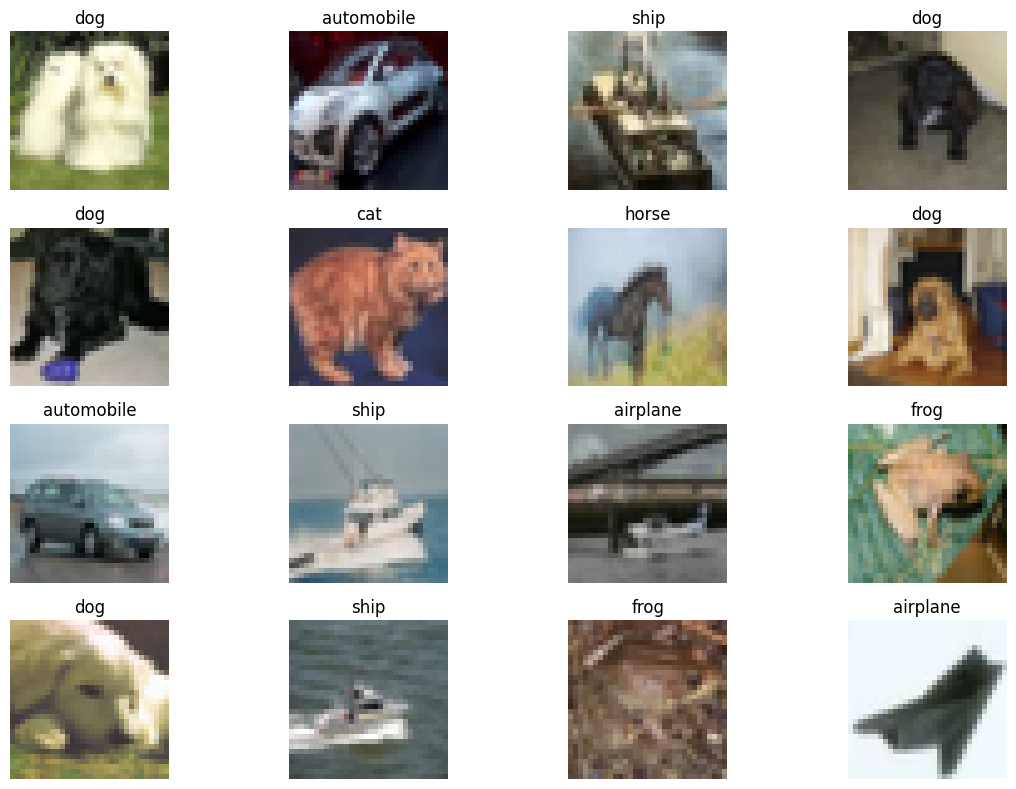

In [13]:
# Visualize sample images
plt.figure(figsize=(12, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    
    # Get first batch
    for images, labels in train_ds.take(1):
        img = images[i].numpy()
        label = labels[i].numpy()
        plt.imshow(img)
        plt.title(f'{CIFAR10_CLASSES[label]}')
        plt.axis('off')
        
plt.tight_layout()
plt.show()

# BUILDING THE BASE CNN MODEL

In [14]:
# Create the Base CNN model

def create_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """Create CNN model"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        
        # Block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),  # Reduces spatial dimensions
        tf.keras.layers.Dropout(0.25),
        
        # Block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Block 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        
        # Classifier
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [15]:
# Train the base CNN model
print("Training Base CNN...")

EPOCHS = 3 # Set global variable for epochs 

model_cnn = create_cnn_model((32, 32, 3), 10)

history_cnn = model_cnn.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

Training Base CNN...
Epoch 1/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 83s 57ms/step - accuracy: 0.4160 - loss: 1.5789 - val_accuracy: 0.5856 - val_loss: 1.1565
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 76s 54ms/step - accuracy: 0.6201 - loss: 1.0716 - val_accuracy: 0.6562 - val_loss: 0.9753
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 70s 50ms/step - accuracy: 0.6733 - loss: 0.9245 - val_accuracy: 0.6966 - val_loss: 0.8830


In [16]:
# Visualization of Training Results

def visualize_training_results(history, title="Model Training"):
    """
    Plot training history for accuracy and loss.
    Args:
        history (tf.keras.callbacks.History): Training history object
        title (str): Title for the plots.
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy of training and validation
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s') 
    ax1.set_title(f'{title} - Accuracy') # 'accuracy' for TF 2.x
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss of training and validation 
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### DATA AUGMENTATION

In [17]:
# Create the augmentation layer

def create_augmentation_layer():
    """
    Create data augmentation layer
    Returns:
        tf.keras.Sequential: Sequential model with augmentation layers.
    """
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1)
    ])

In [18]:
# Create a new model with the augmentation layer added at the model's input

def create_cnn_with_augmentation(input_shape=(32, 32, 3), num_classes=10):
    """
    Create CNN with data augmentation
    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of classes in the dataset.
        Returns:
            tf.keras.Sequential: Sequential model with augmentation layers.
    """
    augmentation = create_augmentation_layer()
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        augmentation,  # Add augmentation at the beginning
        
        # Same CNN architecture as before
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [19]:
# Create and retrain the base CNN model with data augmentation
print("Training CNN with Data Augmentation...")
model_aug = create_cnn_with_augmentation()

history_aug = model_aug.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

Training CNN with Data Augmentation...
Epoch 1/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 89s 61ms/step - accuracy: 0.3551 - loss: 1.7336 - val_accuracy: 0.4816 - val_loss: 1.6409
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 95s 68ms/step - accuracy: 0.5317 - loss: 1.3058 - val_accuracy: 0.5312 - val_loss: 1.3740
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 94s 67ms/step - accuracy: 0.5809 - loss: 1.1846 - val_accuracy: 0.6082 - val_loss: 1.1229


### Compare No Augmentation vs. Augmentation

Training without augmentation
Epoch 1/3


c:\Users\HP\miniconda3\envs\dsp_jblink\lib\site-packages\keras\src\backend\tensorflow\nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 91s 62ms/step - accuracy: 0.4207 - loss: 1.5656 - val_accuracy: 0.4812 - val_loss: 1.5873
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 83s 59ms/step - accuracy: 0.6232 - loss: 1.0608 - val_accuracy: 0.6868 - val_loss: 0.8619
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 84s 60ms/step - accuracy: 0.6745 - loss: 0.9191 - val_accuracy: 0.6220 - val_loss: 1.1500


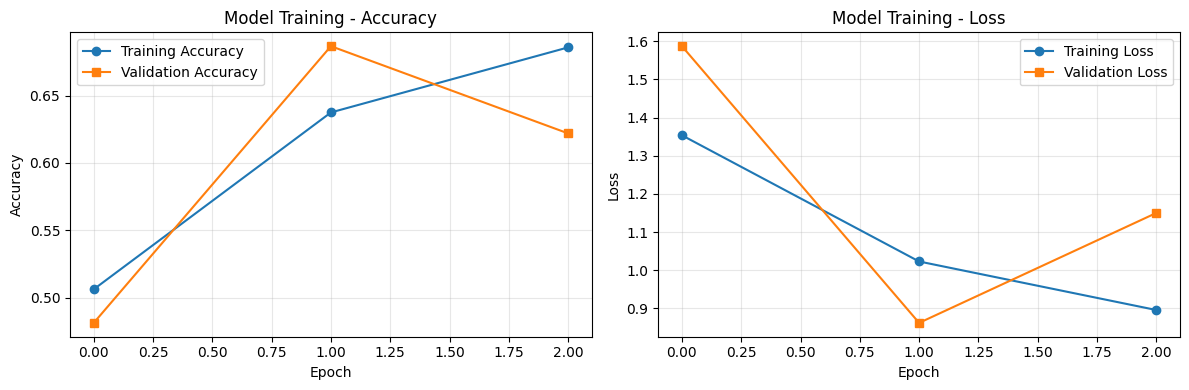

Training with augmentation
Epoch 1/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 84s 58ms/step - accuracy: 0.3647 - loss: 1.7131 - val_accuracy: 0.5156 - val_loss: 1.3470
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 78s 55ms/step - accuracy: 0.5328 - loss: 1.3062 - val_accuracy: 0.5486 - val_loss: 1.3598
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 51ms/step - accuracy: 0.5829 - loss: 1.1758 - val_accuracy: 0.5794 - val_loss: 1.2979


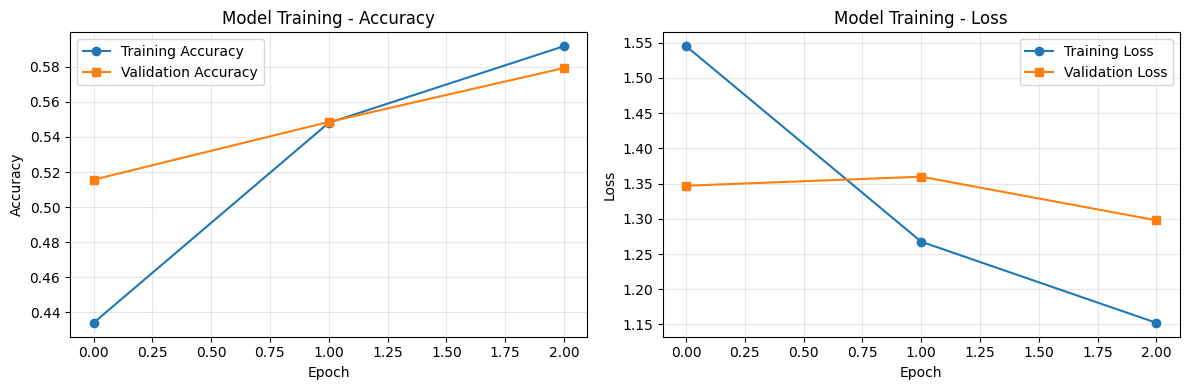

In [20]:
# No Augmentation vs Augmentation
print("Training without augmentation")
model = create_cnn_model((32, 32, 3), 10)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history_no_aug = model.fit(train_ds, validation_data=val_ds, epochs=3)
visualize_training_results(history_no_aug)

print("Training with augmentation")
aug_layer = create_augmentation_layer()
augmented_train_ds = train_ds.map(lambda x, y: (aug_layer(x), y))
model = create_cnn_model((32, 32, 3), 10)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history_aug = model.fit(augmented_train_ds, validation_data=val_ds, epochs=3)
visualize_training_results(history_aug)


### TRANSFER LEARNING

In [21]:
# Create the transfer learning model using ResNet50

def create_transfer_learning_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Create transfer learning model using pretrained ResNet50
    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of classes in the dataset.
    Returns:
        tf.keras.Sequential: Sequential model with transfer learning.
    
    """
    # Load pretrained model
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom head
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [22]:
# Create and train transfer learning model

print("Training Transfer Learning Model (ResNet50)...")
model_transfer = create_transfer_learning_model()

history_transfer = model_transfer.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

Training Transfer Learning Model (ResNet50)...
Epoch 1/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 148s 101ms/step - accuracy: 0.0982 - loss: 2.3500 - val_accuracy: 0.1058 - val_loss: 2.3027
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 140s 100ms/step - accuracy: 0.0958 - loss: 2.3028 - val_accuracy: 0.0976 - val_loss: 2.3028
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7842s 6s/step - accuracy: 0.0983 - loss: 2.3031 - val_accuracy: 0.0986 - val_loss: 2.3027


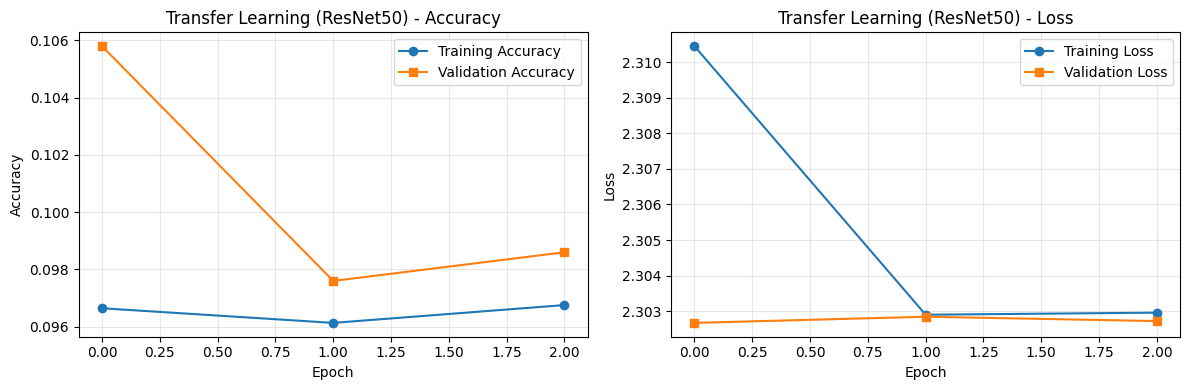

In [23]:
# Visualize training results
visualize_training_results(history_transfer, "Transfer Learning (ResNet50)")

### ADVANCED ANALYSIS

In [24]:
# Function to evaluate the models and show confusion matrix

def evaluate_model(model, test_ds, model_name="Model"):
    """
    Comprehensive model evaluation including:
    - Test accuracy
    - Confusion matrix
    - Classification report with precision, recall, F1-score
    """
    print(f"\n{'='*20} {model_name} Evaluation {'='*20}")
    
    # Get predictions
    y_pred = []
    y_true = []
    
    for x_batch, y_batch in test_ds:
        predictions = model.predict(x_batch, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(y_batch.numpy())
    
    # Test accuracy
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CIFAR10_CLASSES))
    
    return test_acc, y_true, y_pred


==================== Basic CNN Evaluation ====================
Test Accuracy: 0.6705
Test Loss: 0.9201


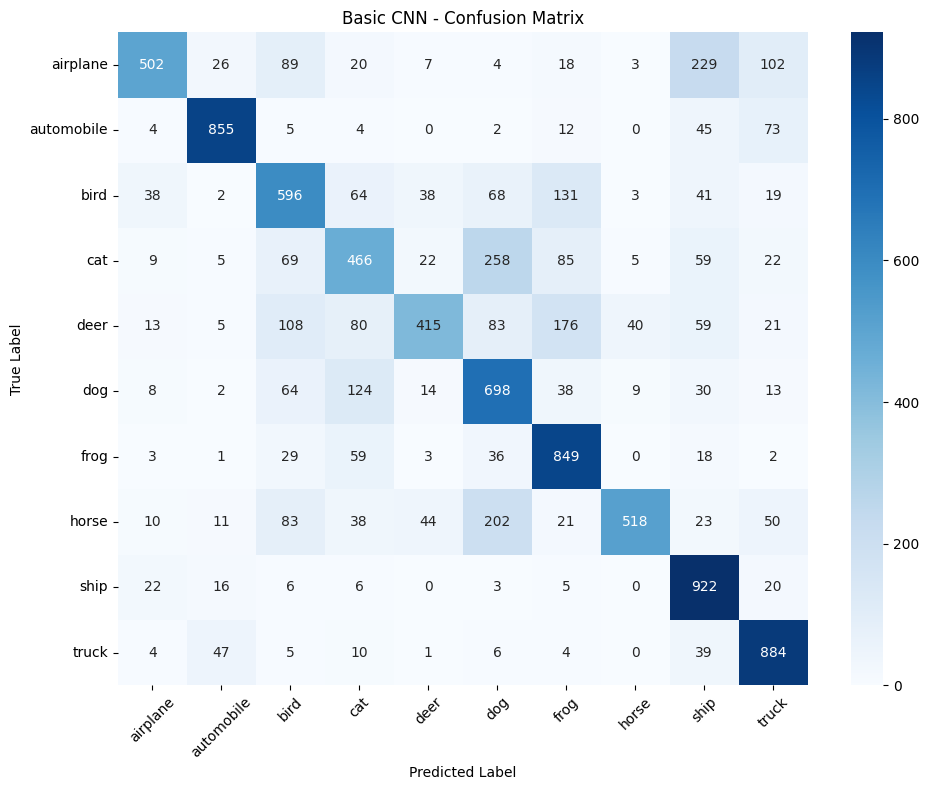


Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.50      0.62      1000
  automobile       0.88      0.85      0.87      1000
        bird       0.57      0.60      0.58      1000
         cat       0.54      0.47      0.50      1000
        deer       0.76      0.41      0.54      1000
         dog       0.51      0.70      0.59      1000
        frog       0.63      0.85      0.73      1000
       horse       0.90      0.52      0.66      1000
        ship       0.63      0.92      0.75      1000
       truck       0.73      0.88      0.80      1000

    accuracy                           0.67     10000
   macro avg       0.70      0.67      0.66     10000
weighted avg       0.70      0.67      0.66     10000


==================== CNN with Augmentation Evaluation ====================
Test Accuracy: 0.6009
Test Loss: 1.1544


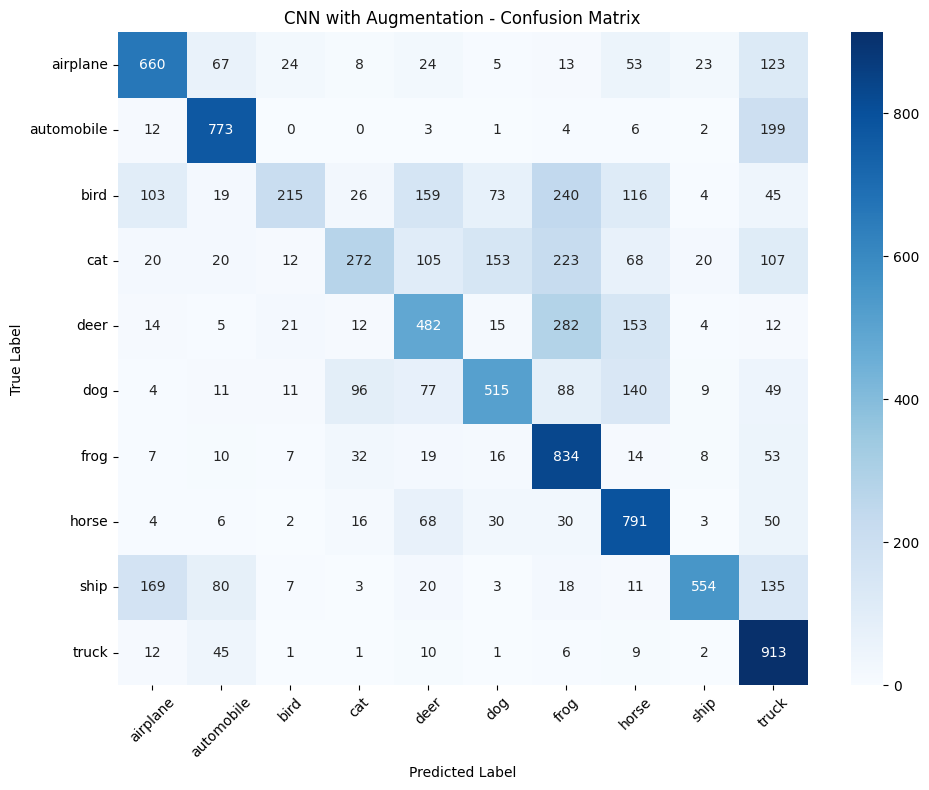


Classification Report:
              precision    recall  f1-score   support

    airplane       0.66      0.66      0.66      1000
  automobile       0.75      0.77      0.76      1000
        bird       0.72      0.21      0.33      1000
         cat       0.58      0.27      0.37      1000
        deer       0.50      0.48      0.49      1000
         dog       0.63      0.52      0.57      1000
        frog       0.48      0.83      0.61      1000
       horse       0.58      0.79      0.67      1000
        ship       0.88      0.55      0.68      1000
       truck       0.54      0.91      0.68      1000

    accuracy                           0.60     10000
   macro avg       0.63      0.60      0.58     10000
weighted avg       0.63      0.60      0.58     10000


==================== Transfer Learning Evaluation ====================
Test Accuracy: 0.1000
Test Loss: 2.3026


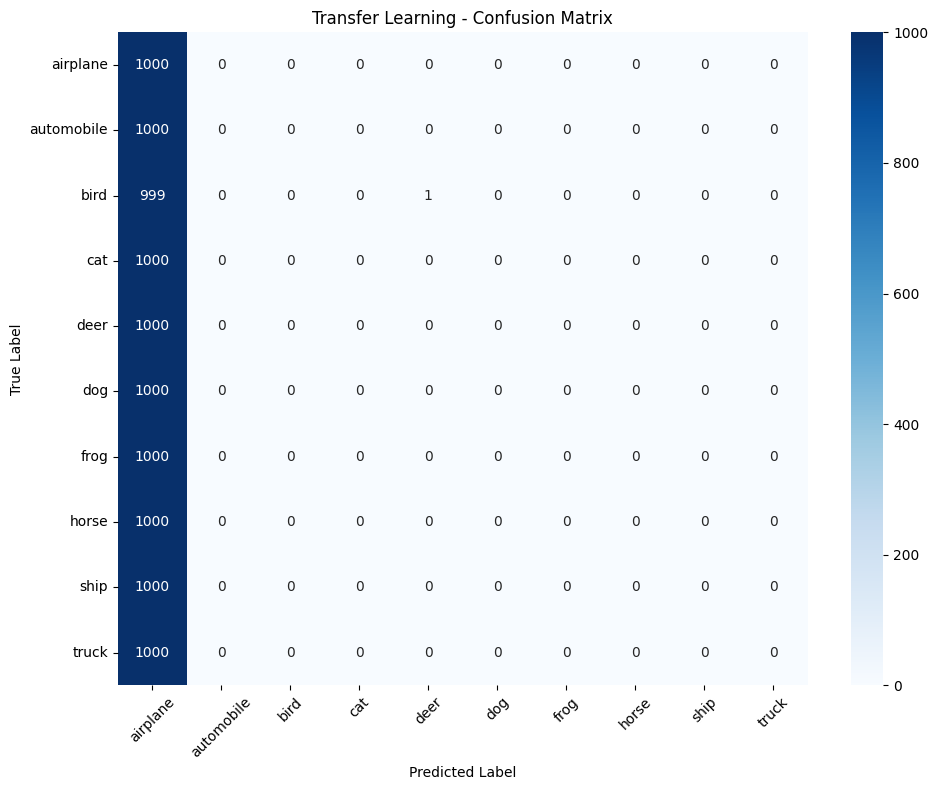


Classification Report:
              precision    recall  f1-score   support

    airplane       0.10      1.00      0.18      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



c:\Users\HP\miniconda3\envs\dsp_jblink\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\miniconda3\envs\dsp_jblink\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\miniconda3\envs\dsp_jblink\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [25]:
# Evaluate all the three models
results = {}

# Basic CNN
acc_cnn, y_true_cnn, y_pred_cnn = evaluate_model(model_cnn, test_ds, "Basic CNN")
results['Base CNN'] = acc_cnn

# CNN with Augmentation
acc_aug, y_true_aug, y_pred_aug = evaluate_model(model_aug, test_ds, "CNN with Augmentation")
results['CNN + Augmentation'] = acc_aug

# Transfer Learning
acc_transfer, y_true_transfer, y_pred_transfer = evaluate_model(model_transfer, test_ds, "Transfer Learning")
results['Transfer Learning'] = acc_transfer


FINAL RESULTS COMPARISON


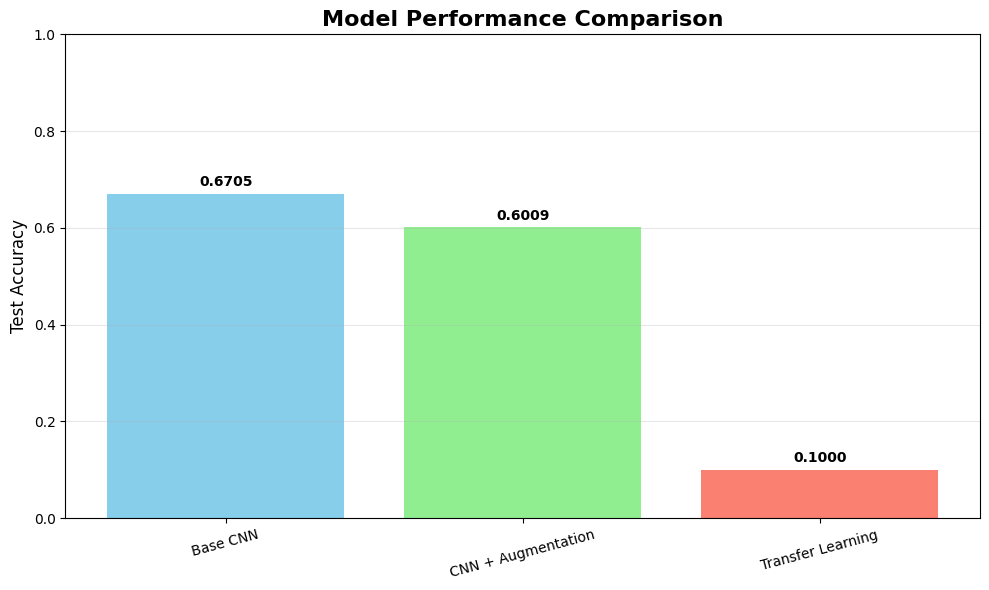

In [26]:
# Compare all models

print("FINAL RESULTS COMPARISON")

# Create comparison plot
models = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# Print results table

print(f"{'Model':<20} {'Test Accuracy':<15}")
print("-" * 35)
for model_name, accuracy in results.items():
    print(f"{model_name:<20} {accuracy:<15.4f}")

best_model = max(results, key=results.get)
print(f"\nBest performing model: {best_model} ({results[best_model]:.4f})")


Model                Test Accuracy  
-----------------------------------
Base CNN             0.6705         
CNN + Augmentation   0.6009         
Transfer Learning    0.1000         

Best performing model: Base CNN (0.6705)


In [28]:
 # Create misclassified images plot

def show_misclassified_images(model, test_ds, model_name, num_examples=8):
    """Show examples of misclassified images"""
    print(f"\nMisclassified Examples for {model_name}:")
    
    misclassified_images = []
    misclassified_true = []
    misclassified_pred = []
    
    for x_batch, y_batch in test_ds:
        predictions = model.predict(x_batch, verbose=0)
        pred_classes = np.argmax(predictions, axis=1)
        
        for i in range(len(x_batch)):
            if pred_classes[i] != y_batch[i] and len(misclassified_images) < num_examples:
                misclassified_images.append(x_batch[i])
                misclassified_true.append(y_batch[i])
                misclassified_pred.append(pred_classes[i])
    
    # Plot misclassified examples
    plt.figure(figsize=(12, 6))
    for i in range(min(num_examples, len(misclassified_images))):
        plt.subplot(2, 4, i+1)
        plt.imshow(misclassified_images[i])
        true_label = CIFAR10_CLASSES[misclassified_true[i]]
        pred_label = CIFAR10_CLASSES[misclassified_pred[i]]
        plt.title(f'True: {true_label}\nPred: {pred_label}', fontsize=10)
        plt.axis('off')
    
    plt.suptitle(f'{model_name} - Misclassified Examples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


Misclassified Examples for Base CNN:


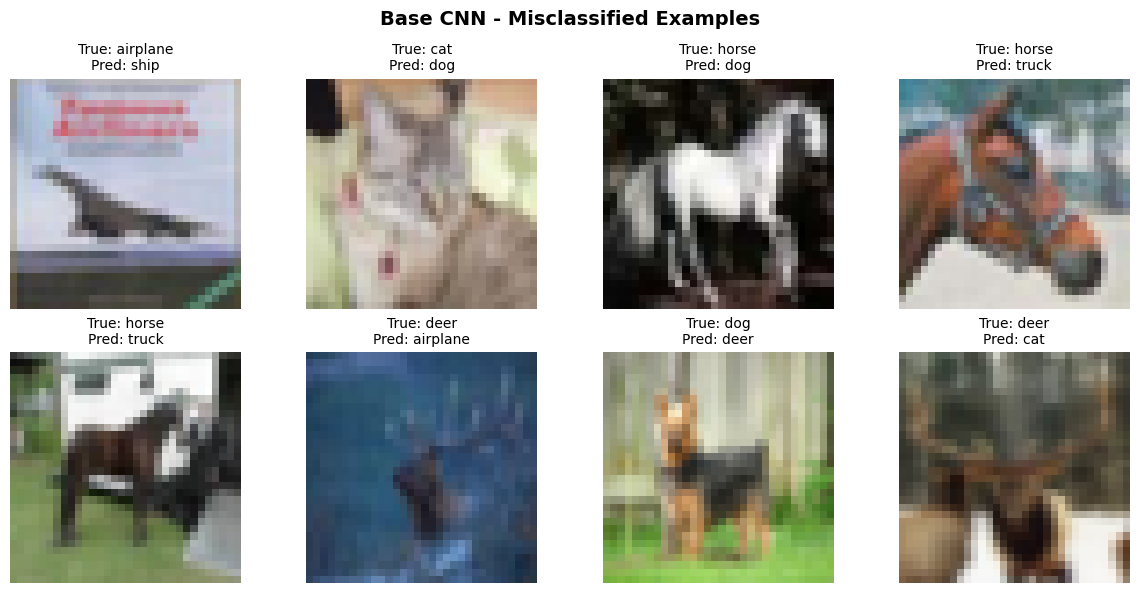

In [29]:
# Show misclassified examples for the best model
best_model_obj = model_transfer if results['Transfer Learning'] == max(results.values()) else \
                 (model_aug if results['CNN + Augmentation'] == max(results.values()) else model_cnn)
show_misclassified_images(best_model_obj, test_ds, best_model)


In [30]:
# ### CLASS-WISE EVALUATION METRICS: Calculate precision, recall, and F1-score for each class

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model_cnn.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=CIFAR10_CLASSES))

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
              precision    recall  f1-score   support

    airplane       0.82      0.50      0.62      1000
  automobile       0.88      0.85      0.87      1000
        bird       0.57      0.60      0.58      1000
         cat       0.54      0.47      0.50      1000
        deer       0.76      0.41      0.54      1000
         dog       0.51      0.70      0.59      1000
        frog       0.63      0.85      0.73      1000
       horse       0.90      0.52      0.66      1000
        ship       0.63      0.92      0.75      1000
       truck       0.73      0.88      0.80      1000

    accuracy                           0.67     10000
   macro avg       0.70      0.67      0.66     10000
weighted avg       0.70      0.67      0.66     10000



### EXPLORATION PART A

##### Learning Rate Scheduling
Try using a learning rate scheduler that reduces the learning rate when validation accuracy stops improving.

In [31]:
# Add a learning rate scheduler callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=3,
    verbose=1
)

In [32]:
model = create_cnn_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs= EPOCHS, callbacks=[reduce_lr])

Epoch 1/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 50ms/step - accuracy: 0.4141 - loss: 1.5733 - val_accuracy: 0.4700 - val_loss: 1.5313 - learning_rate: 0.0010
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 71s 50ms/step - accuracy: 0.6223 - loss: 1.0596 - val_accuracy: 0.6826 - val_loss: 0.8985 - learning_rate: 0.0010
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 64s 46ms/step - accuracy: 0.6790 - loss: 0.9088 - val_accuracy: 0.6440 - val_loss: 1.0125 - learning_rate: 0.0010


### DEEPER CNN MODEL


In [33]:
# Create deeper CNN model with more layers to cature complex features

def create_deeper_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [34]:
# Create and train the deeper CNN model
import time

print("Training Deeper CNN...")
start_time = time.time()

deeper_model = create_deeper_cnn_model((32, 32, 3), num_classes)
deeper_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_deeper = deeper_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

deeper_training_time = time.time() - start_time 
print(f"Deeper CNN training time: {deeper_training_time:.2f} seconds")

Training Deeper CNN...
Epoch 1/3


c:\Users\HP\miniconda3\envs\dsp_jblink\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 84s 58ms/step - accuracy: 0.4172 - loss: 1.7122 - val_accuracy: 0.5540 - val_loss: 1.2445
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 84s 60ms/step - accuracy: 0.6460 - loss: 1.0058 - val_accuracy: 0.5658 - val_loss: 1.2153
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.7027 - loss: 0.8450 - val_accuracy: 0.7350 - val_loss: 0.7877
Deeper CNN training time: 250.77 seconds


### WIDER CNN MODEL

In [35]:
# Create model with fewer layers and more filters per layer

def create_wider_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [36]:
# Create and train the wider CNN model

print("Training Wider CNN...")
start_time = time.time()

wider_model = create_wider_cnn_model((32, 32, 3), num_classes)
wider_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_wider = wider_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

wider_training_time = time.time() - start_time  
print(f"Wider CNN training time: {wider_training_time:.2f} seconds")

Training Wider CNN...
Epoch 1/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 108s 75ms/step - accuracy: 0.4006 - loss: 1.7782 - val_accuracy: 0.5746 - val_loss: 1.2191
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2417s 2s/step - accuracy: 0.5973 - loss: 1.1238 - val_accuracy: 0.5656 - val_loss: 1.2208
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 107s 76ms/step - accuracy: 0.6578 - loss: 0.9674 - val_accuracy: 0.3796 - val_loss: 2.3378
Wider CNN training time: 2631.81 seconds


### Network Depth vs. Width


==================== Deeper CNN Evaluation ====================
Test Accuracy: 0.7239
Test Loss: 0.8092


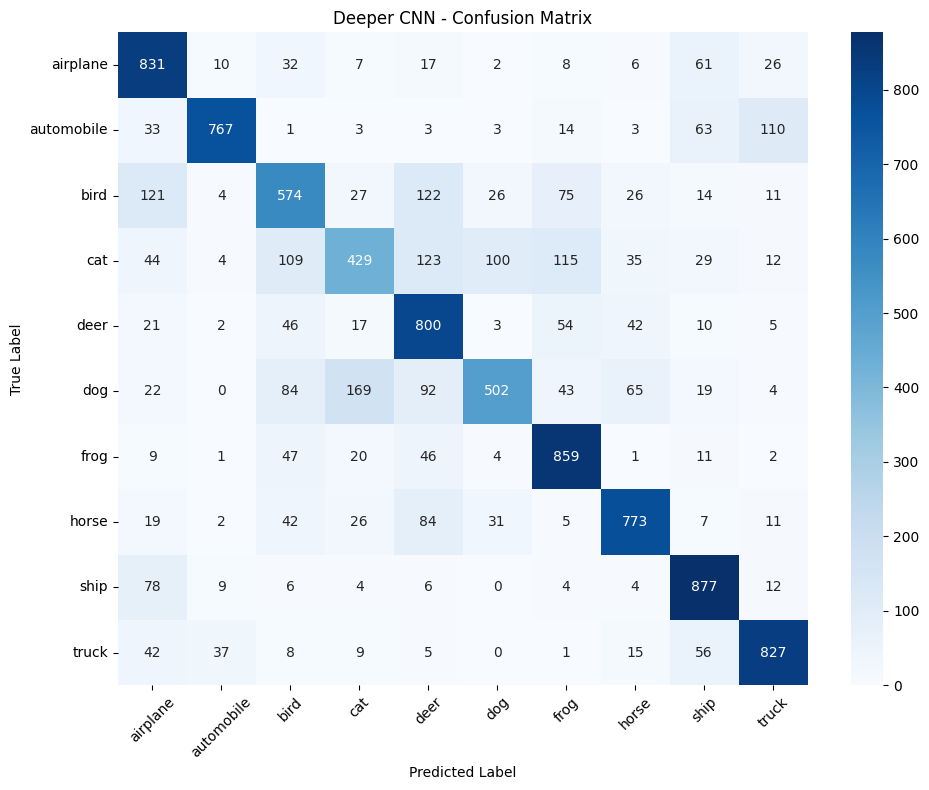


Classification Report:
              precision    recall  f1-score   support

    airplane       0.68      0.83      0.75      1000
  automobile       0.92      0.77      0.84      1000
        bird       0.60      0.57      0.59      1000
         cat       0.60      0.43      0.50      1000
        deer       0.62      0.80      0.70      1000
         dog       0.75      0.50      0.60      1000
        frog       0.73      0.86      0.79      1000
       horse       0.80      0.77      0.78      1000
        ship       0.76      0.88      0.82      1000
       truck       0.81      0.83      0.82      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000


==================== Wider CNN Evaluation ====================
Test Accuracy: 0.3811
Test Loss: 2.3592


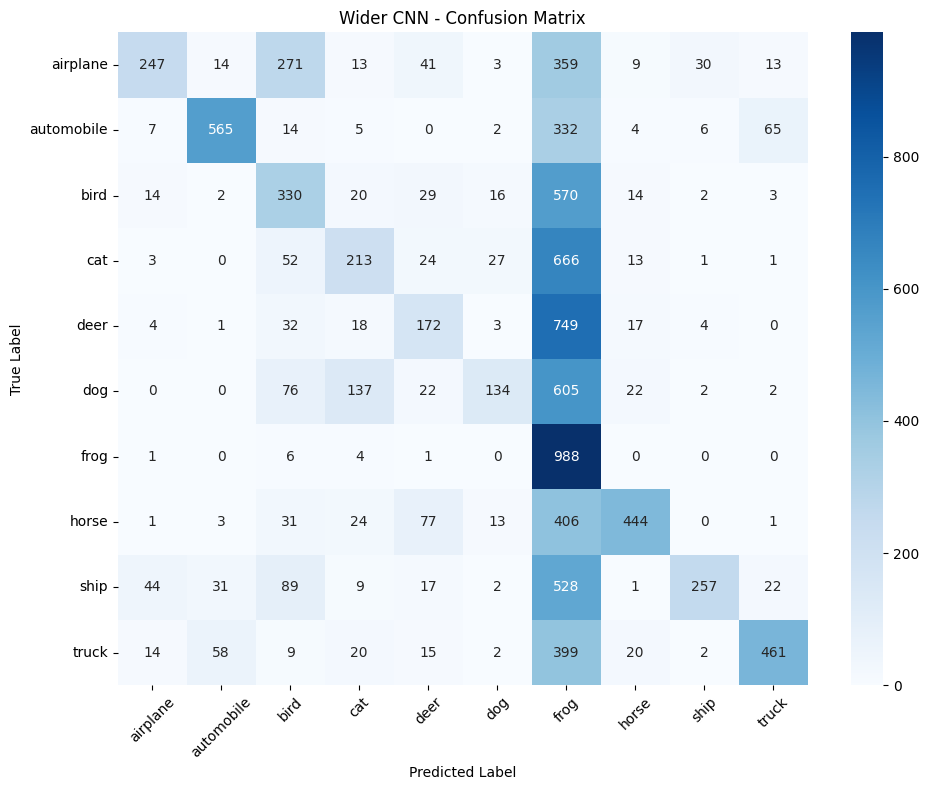


Classification Report:
              precision    recall  f1-score   support

    airplane       0.74      0.25      0.37      1000
  automobile       0.84      0.56      0.68      1000
        bird       0.36      0.33      0.35      1000
         cat       0.46      0.21      0.29      1000
        deer       0.43      0.17      0.25      1000
         dog       0.66      0.13      0.22      1000
        frog       0.18      0.99      0.30      1000
       horse       0.82      0.44      0.58      1000
        ship       0.85      0.26      0.39      1000
       truck       0.81      0.46      0.59      1000

    accuracy                           0.38     10000
   macro avg       0.61      0.38      0.40     10000
weighted avg       0.61      0.38      0.40     10000


FINAL COMPARISON SUMMARY
Deeper CNN  - Test Accuracy: 0.7239 | Parameters: 592,042
Wider CNN   - Test Accuracy: 0.3811 | Parameters: 1,126,410
Deeper CNN (better by 34.28%)


In [37]:
# Compare Performace by extracting the accuracy from evaluate_model return value

deeper_results = evaluate_model(deeper_model, test_ds, "Deeper CNN")
deeper_acc = deeper_results if isinstance(deeper_results, float) else deeper_results[0]

wider_results = evaluate_model(wider_model, test_ds, "Wider CNN")
wider_acc = wider_results if isinstance(wider_results, float) else wider_results[0]

print("\n" + "="*50)
print("FINAL COMPARISON SUMMARY")
print("="*50)
print(f"Deeper CNN  - Test Accuracy: {deeper_acc:.4f} | Parameters: {deeper_model.count_params():,}")
print(f"Wider CNN   - Test Accuracy: {wider_acc:.4f} | Parameters: {wider_model.count_params():,}")

if deeper_acc > wider_acc:
    print(f"Deeper CNN (better by {(deeper_acc-wider_acc)*100:.2f}%)")
else:
    print(f"Wider CNN (better by {(wider_acc-deeper_acc)*100:.2f}%)")

In [38]:
# Compare the training speed of deeper and wider models

print("\n" + "="*50)
print("TRAINING SPEED COMPARISON")
print("="*50)

print(f"Deeper CNN - Training time: {deeper_training_time:.2f} seconds")
print(f"Wider CNN  - Training time: {wider_training_time:.2f} seconds")

if deeper_training_time < wider_training_time:
    time_saved = wider_training_time - deeper_training_time
    print(f"Deeper CNN (faster by {time_saved:.2f} seconds)")
else:
    time_saved = deeper_training_time - wider_training_time
    print(f"Wider CNN (faster by {time_saved:.2f} seconds)")

# Additional speed metrics
print(f"\nTime per epoch:")
print(f"Deeper CNN: {deeper_training_time/EPOCHS:.2f} seconds/epoch")
print(f"Wider CNN:  {wider_training_time/EPOCHS:.2f} seconds/epoch")


TRAINING SPEED COMPARISON
Deeper CNN - Training time: 250.77 seconds
Wider CNN  - Training time: 2631.81 seconds
Deeper CNN (faster by 2381.04 seconds)

Time per epoch:
Deeper CNN: 83.59 seconds/epoch
Wider CNN:  877.27 seconds/epoch


### Batch Size Experiments 

Training with batch size = 32
Loading CIFAR-10...
Epoch 1/3


c:\Users\HP\miniconda3\envs\dsp_jblink\lib\site-packages\keras\src\backend\tensorflow\nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - accuracy: 0.4044 - loss: 1.6020 - val_accuracy: 0.5322 - val_loss: 1.2642
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 92s 65ms/step - accuracy: 0.6191 - loss: 1.0658 - val_accuracy: 0.6136 - val_loss: 1.1074
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 85s 61ms/step - accuracy: 0.6749 - loss: 0.9296 - val_accuracy: 0.7120 - val_loss: 0.8141
Batch size 32 - Training time: 259.56s, Test accuracy: 0.6960
Training with batch size = 64
Loading CIFAR-10...
Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 112ms/step - accuracy: 0.4039 - loss: 1.5969 - val_accuracy: 0.5398 - val_loss: 1.3047
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 111ms/step - accuracy: 0.6297 - loss: 1.0383 - val_accuracy: 0.6618 - val_loss: 1.0046
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 111ms/step - accuracy: 0.6810 - loss: 0.9021 - val_accuracy: 0.7376 - val_loss: 0.7713
Batch size 64 - Training time: 238.92s, Test accuracy: 0.7185
Training with batch size = 256
Loading CIFAR-10...
Ep

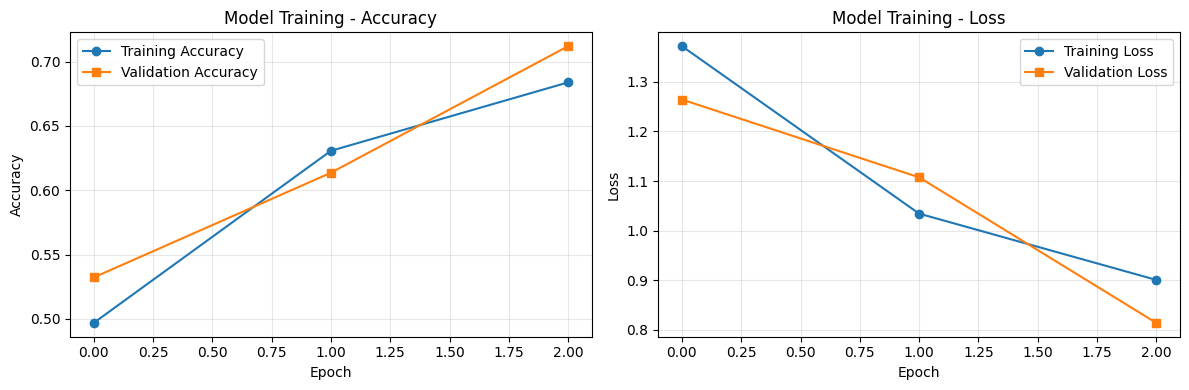


Training curves for batch size 64:


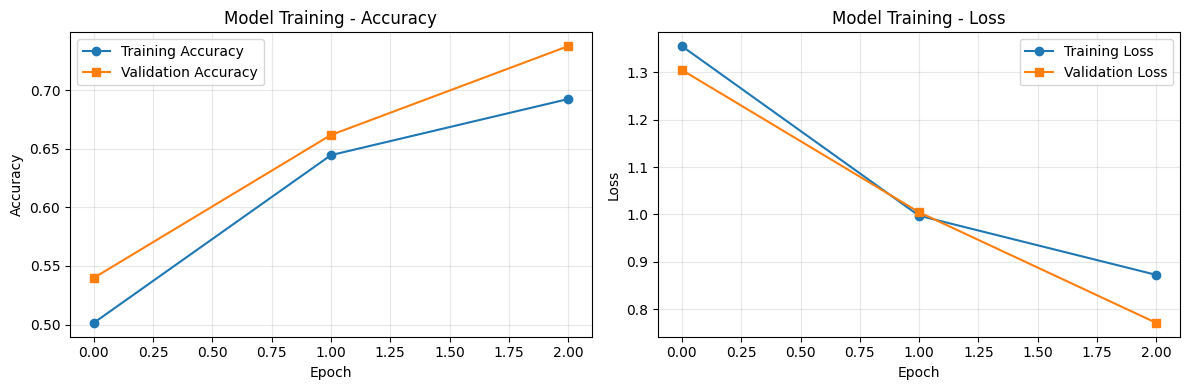


Training curves for batch size 256:


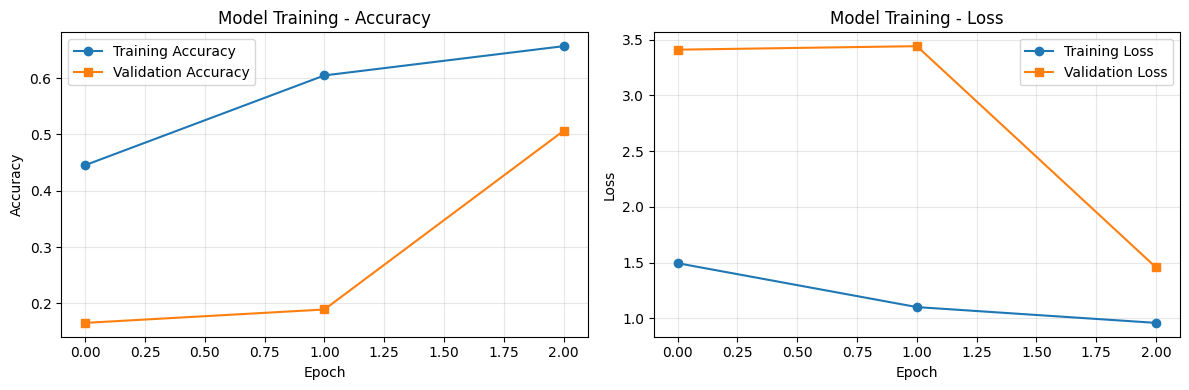

In [39]:
# Vary batch size and observe the impact on training time and accuracy
batch_results = {} 

batch_sizes = [32, 64, 256]
for bs in batch_sizes:
    print(f"Training with batch size = {bs}")
    # Fix: Unpack all 4 returned values
    train_ds, val_ds, test_ds, num_classes = load_and_prepare_cifar10(batch_size=bs)
    
    model = create_cnn_model((32, 32, 3), 10)
    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])
    
     # Time the training
    start_time = time.time()
    history = model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=EPOCHS,
        verbose=1
    )
    training_time = time.time() - start_time
    
    
     # Evaluate final performance
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    
    # Store results
    batch_results[bs] = {
        'history': history,
        'training_time': training_time,
        'test_accuracy': test_acc,
        'final_train_acc': history.history['accuracy'][-1],
        'final_val_acc': history.history['val_accuracy'][-1]
    }
    
    print(f"Batch size {bs} - Training time: {training_time:.2f}s, Test accuracy: {test_acc:.4f}")
    
    
# Visualize individual training curves
for bs in batch_sizes:
    print(f"\nTraining curves for batch size {bs}:")
    visualize_training_results(batch_results[bs]['history'])

In [40]:
# Batch size comparison summary

print("\n" + "="*70)
print("BATCH SIZE COMPARISON SUMMARY")
print("="*70)

print(f"{'Batch Size':<12} {'Training Time':<15} {'Test Accuracy':<15} {'Convergence':<15}")
print("-" * 70)

for bs in batch_sizes:
    results = batch_results[bs]
    convergence = "Fast" if results['final_val_acc'] > 0.7 else "Slow"
    print(f"{bs:<12} {results['training_time']:.2f}s{'':<9} {results['test_accuracy']:.4f}{'':<9} {convergence:<15}")

# Find best performing batch size
best_batch_size = max(batch_results.keys(), key=lambda x: batch_results[x]['test_accuracy'])
fastest_batch_size = min(batch_results.keys(), key=lambda x: batch_results[x]['training_time'])

print(f"\nBest Accuracy: Batch size {best_batch_size} ({batch_results[best_batch_size]['test_accuracy']:.4f})")
print(f"Fastest Training: Batch size {fastest_batch_size} ({batch_results[fastest_batch_size]['training_time']:.2f}s)")


BATCH SIZE COMPARISON SUMMARY
Batch Size   Training Time   Test Accuracy   Convergence    
----------------------------------------------------------------------
32           259.56s          0.6960          Fast           
64           238.92s          0.7185          Fast           
256          243.27s          0.4991          Slow           

Best Accuracy: Batch size 64 (0.7185)
Fastest Training: Batch size 64 (238.92s)


### Optimizer Comparison

Training with optimizer = SGD
Epoch 1/3
176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 477ms/step - accuracy: 0.1769 - loss: 2.1913 - val_accuracy: 0.0956 - val_loss: 2.3839
Epoch 2/3
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 496ms/step - accuracy: 0.2859 - loss: 1.9063 - val_accuracy: 0.1002 - val_loss: 2.6376
Epoch 3/3
176/176 ━━━━━━━━━━━━━━━━━━━━ 100s 568ms/step - accuracy: 0.3240 - loss: 1.7885 - val_accuracy: 0.1980 - val_loss: 2.2608


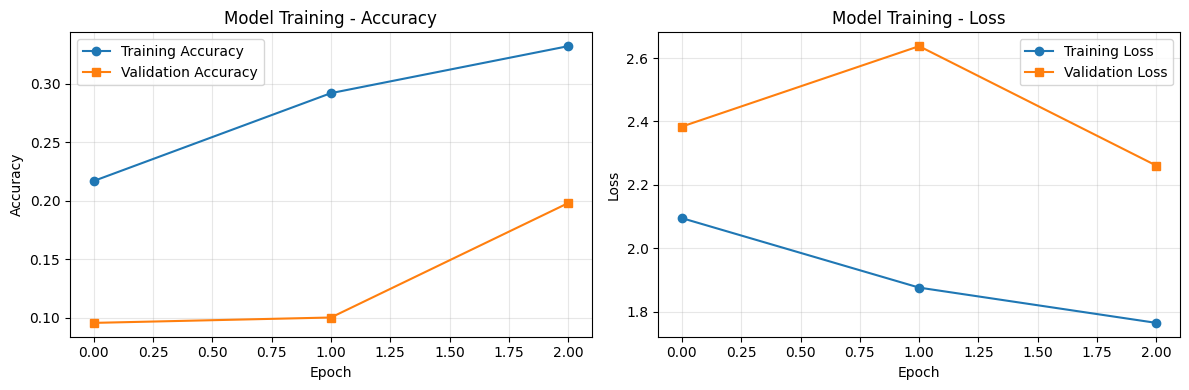

Training with optimizer = RMSProp
Epoch 1/3
176/176 ━━━━━━━━━━━━━━━━━━━━ 92s 507ms/step - accuracy: 0.3647 - loss: 1.7105 - val_accuracy: 0.0986 - val_loss: 4.6920
Epoch 2/3
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 448ms/step - accuracy: 0.5841 - loss: 1.1527 - val_accuracy: 0.2476 - val_loss: 2.7773
Epoch 3/3
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 432ms/step - accuracy: 0.6468 - loss: 0.9912 - val_accuracy: 0.3848 - val_loss: 2.1743


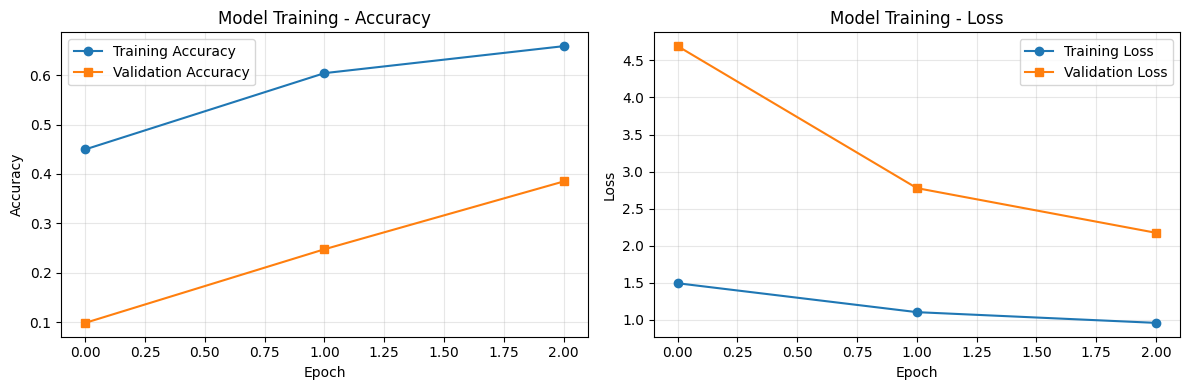

Training with optimizer = Adam
Epoch 1/3
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 460ms/step - accuracy: 0.3573 - loss: 1.7104 - val_accuracy: 0.0994 - val_loss: 3.9114
Epoch 2/3
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 445ms/step - accuracy: 0.5780 - loss: 1.1608 - val_accuracy: 0.1968 - val_loss: 3.2268
Epoch 3/3
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 468ms/step - accuracy: 0.6482 - loss: 0.9816 - val_accuracy: 0.4760 - val_loss: 1.5788


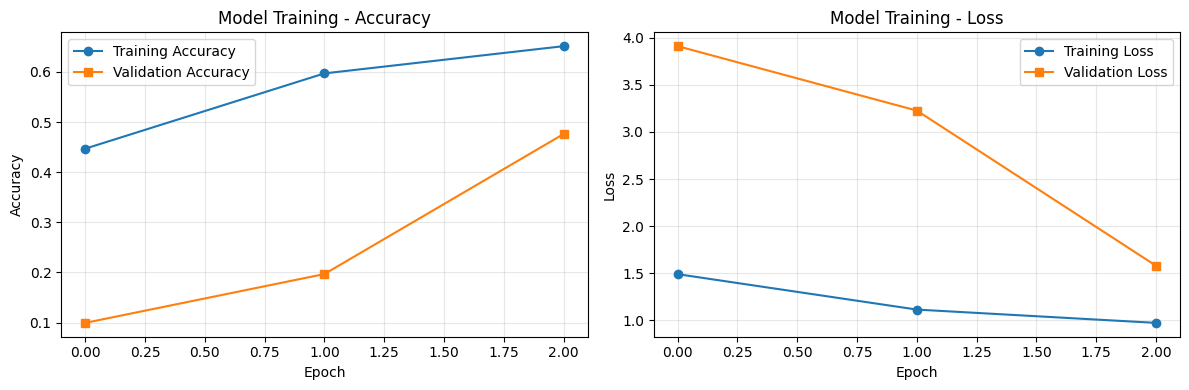

In [41]:
# Optimizer Comparison

optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'RMSProp': tf.keras.optimizers.RMSprop(),
    'Adam': tf.keras.optimizers.Adam()
}
for name, opt in optimizers.items():
    print(f"Training with optimizer = {name}")
    model = create_cnn_model((32, 32, 3), 10)
    model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
    visualize_training_results(history)
